In [1]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_lg")
#nlp.add_pipe('merge_noun_chunks')
import numpy as np
import pandas as pd
import sys
import re
import pickle
from matplotlib.colors import is_color_like as color_check
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

%matplotlib inline

In [2]:
species_dict = pickle.load(open('knowledge_graph.pkl', 'rb'))

In [3]:
species_dict.keys()

dict_keys(['Hirtella', 'Murdannia', 'Stipa karjaginii', 'Cassia burttii', 'Sesamum angolense', 'Ceropegia floribundior', 'Lamarckia', 'Ehretia janjalle', 'Amphibromus scabrivalvis', 'Garnotia exaristata'])

In [4]:
sents = [sent for sent in species_dict['Murdannia']]
species = 'Murdannia'

In [16]:
def knowledge_df(triple_list):
    
    """
    Creates a df with triples from a nested list with tuples.
    """
    
    # create flatlist
    knowledge_list_flat = [RDF for RDF_list in triple_list for RDF in RDF_list]
    
    # Extract the source
    source = [source[0].lower().strip() for knowledge in knowledge_list_flat for source in knowledge]
    # Extract relation
    relation = [source[1].lower().strip() for knowledge in knowledge_list_flat for source in knowledge]
    # Extract target
    target = [source[2].lower().strip() for knowledge in knowledge_list_flat for source in knowledge]
    
    # Return the df
    return pd.DataFrame({'source':source, 'target':target, 'edge':relation})

def plot_kg(kg_df):
    
    """
    plots the dataframe with triples.
    """
    
    G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                              edge_attr=True, create_using=nx.MultiDiGraph())

    plt.figure(figsize=(40, 40))
    labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                      kg_df['edge'].tolist()))
    pos = nx.spring_layout(G, k = 0.5)
    nx.draw(G, with_labels=True, node_size=2500, pos = pos)
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels,
                                     font_color='red')
    plt.show()
    
    
def extract_adjectives_verb(sent):
    
    RDF = []
    sent = nlp(sent)

    for token in sent:
        # Find AUX
        if token.pos_ == 'AUX':
            # Get the children
            children = [child for child in token.subtree]
            for child in children:
                # CHeck if child is VERB
                if child.pos_ == 'VERB':
                    # Append if common ancestor
                    if token == list(child.ancestors)[-1] and not sent[token.i-1].is_punct and not sent[token.i-1].is_stop:
                        RDF.append((sent[token.i-1].lemma_, token.lemma_, child.text))
                        RDF.append((species, 'has part', sent[token.i-1].lemma_))
    # Drop dups and empties
    RDF = [triple for triple in RDF 
           if triple[0] != triple[2]
           if triple[2] != ''
           if triple[0] != '']
    RDF = list(set(RDF))       
    
    return RDF    

def extract_adjectives_adjectives(sent):
    
    RDF = []
    sent = nlp(sent)

    for token in sent:
        # Find AUX
        if token.pos_ == 'AUX':
            # Get the children
            children = [child for child in token.subtree]
            for child in children:
                # CHeck if child is VERB
                if child.pos_ == 'ADJ':
                    # Append if common ancestor
                    if token == list(child.ancestors)[-1] and not sent[token.i-1].is_punct and not sent[token.i-1].is_stop:
                        #print(sentlist(child.ancestors)[-1].i-1)
                        RDF.append((sent[token.i-1].lemma_, token.lemma_, child.text))
                        RDF.append((species, 'has part', sent[token.i-1].lemma_))
                        
    # Drop dups and empties
    RDF = [triple for triple in RDF 
           if triple[0] != triple[2]
           if triple[2] != ''
           if triple[0] != '']
    RDF = list(set(RDF))       
    
    return RDF

def extract_adjectives_measurements(sent):
    
    RDF = []
    sent = nlp(sent)
    
    # Get quantities
    quantities = [ent for ent in sent.ents if ent.label_ == 'QUANTITY']
    cardinals  = [ent for ent in sent.ents if ent.label_ == 'CARDINAL']
    parent, grandparent, ggparent, gggparent = ('','','','',)
        
    for quantity in quantities:    
        # Get word next to quantity
        q_header = sent[quantity[-1].i + 1]
        # Help the depency parser a bit for missed items:
        if quantity[-1].pos_ == 'NUM':
            q_header = sent[quantity[-1].i + 2]
        #print(q_header)
        if q_header.pos_ == 'ADJ':
            # Get parent
            #print(q_header)
            parent = list(q_header.ancestors)[0]
            
            
            try:
                ### MIGHT NEED ADJUSTMENTS
                if parent.pos_ == 'VERB':
                    grandparent = list(parent.ancestors)[0]
                    if grandparent.text == 'is':
                        RDF.append((species, parent.lemma_, quantity.text))
                        continue

                # Fix some qorks
                if parent.pos_ == 'NUM' or parent.pos_ == 'PUNCT' or parent.is_stop:
                    parent = list(q_header.ancestors)[1]
                if parent.text.lower().strip() in ['wide', 'long', 'broad',]:
                    parent = list(q_header.ancestors)[1]
                RDF.append((parent.lemma_, 'be', quantity.text + ' ' + q_header.text))

                # Exhaust the list
                try:            
                    # Get grandparent
                    grandparent = list(parent.ancestors)[0]
                    RDF.append((grandparent.lemma_, 'has part', parent.lemma_))
                except:
                    RDF.append((species, 'has part', parent.lemma_))
                    continue
                try:
                    # Get parent of grandparent
                    ggparent = list(grandparent.ancestors)[0]
                    RDF.append((ggparent.lemma_, 'has part', grandparent.lemma_))
                except:
                    RDF.append((species, 'has part', grandparent.lemma_))
                    continue
                try:
                    # Get parent of grandparent
                    gggparent = list(ggparent.ancestors)[0]
                    RDF.append((gggparent.lemma_, 'has part', ggparent.lemma_))
                except:
                    RDF.append((species, 'has part', grandparent.lemma_))
                    continue
            except:
                continue
    return RDF

def extract_adjectives_nouns(sent):
    
    RDF = []
    sent = nlp(sent)

    for idx, token in enumerate(sent):
        try:
            # Skip if future exists
            if sent[idx+1].pos_ == 'NOUN' or sent[idx+1].pos_ == 'ADJ':
                continue
            # Find NOUN and ADJ tokens
            if token.pos_ == 'NOUN' or token.pos_ == 'ADJ':
                # Skip start
                if token.i == 0:
                    continue
                # Get candidate
                for child in token.children:
                    # check if really amod
                    if child.dep_ == 'amod' or child.dep_ == 'npadvmod':
                        #print(child)
                        # If no subtree append
                        if len(list(child.subtree)) == 1:
                            RDF.append((token.text, 'be', child.text))
                        elif len(list(child.subtree)) > 1:
                            RDF.append((token.text, 'be', ' '.join([grandchild.text for grandchild in child.subtree])))

        except:
            continue

    return RDF

In [17]:
#[(extract_parts(sent), count) for count, sent in enumerate(sents)]
#test = [(extract_parts(sent),) for sent in sents]


In [18]:
triples = []

for species, sents in tqdm(species_dict.items()):
    # Get triples
    triples += [(extract_adjectives_verb(sent), extract_adjectives_adjectives(sent), extract_adjectives_nouns(sent)) for sent in sents] #

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


In [19]:
df = knowledge_df(triples)

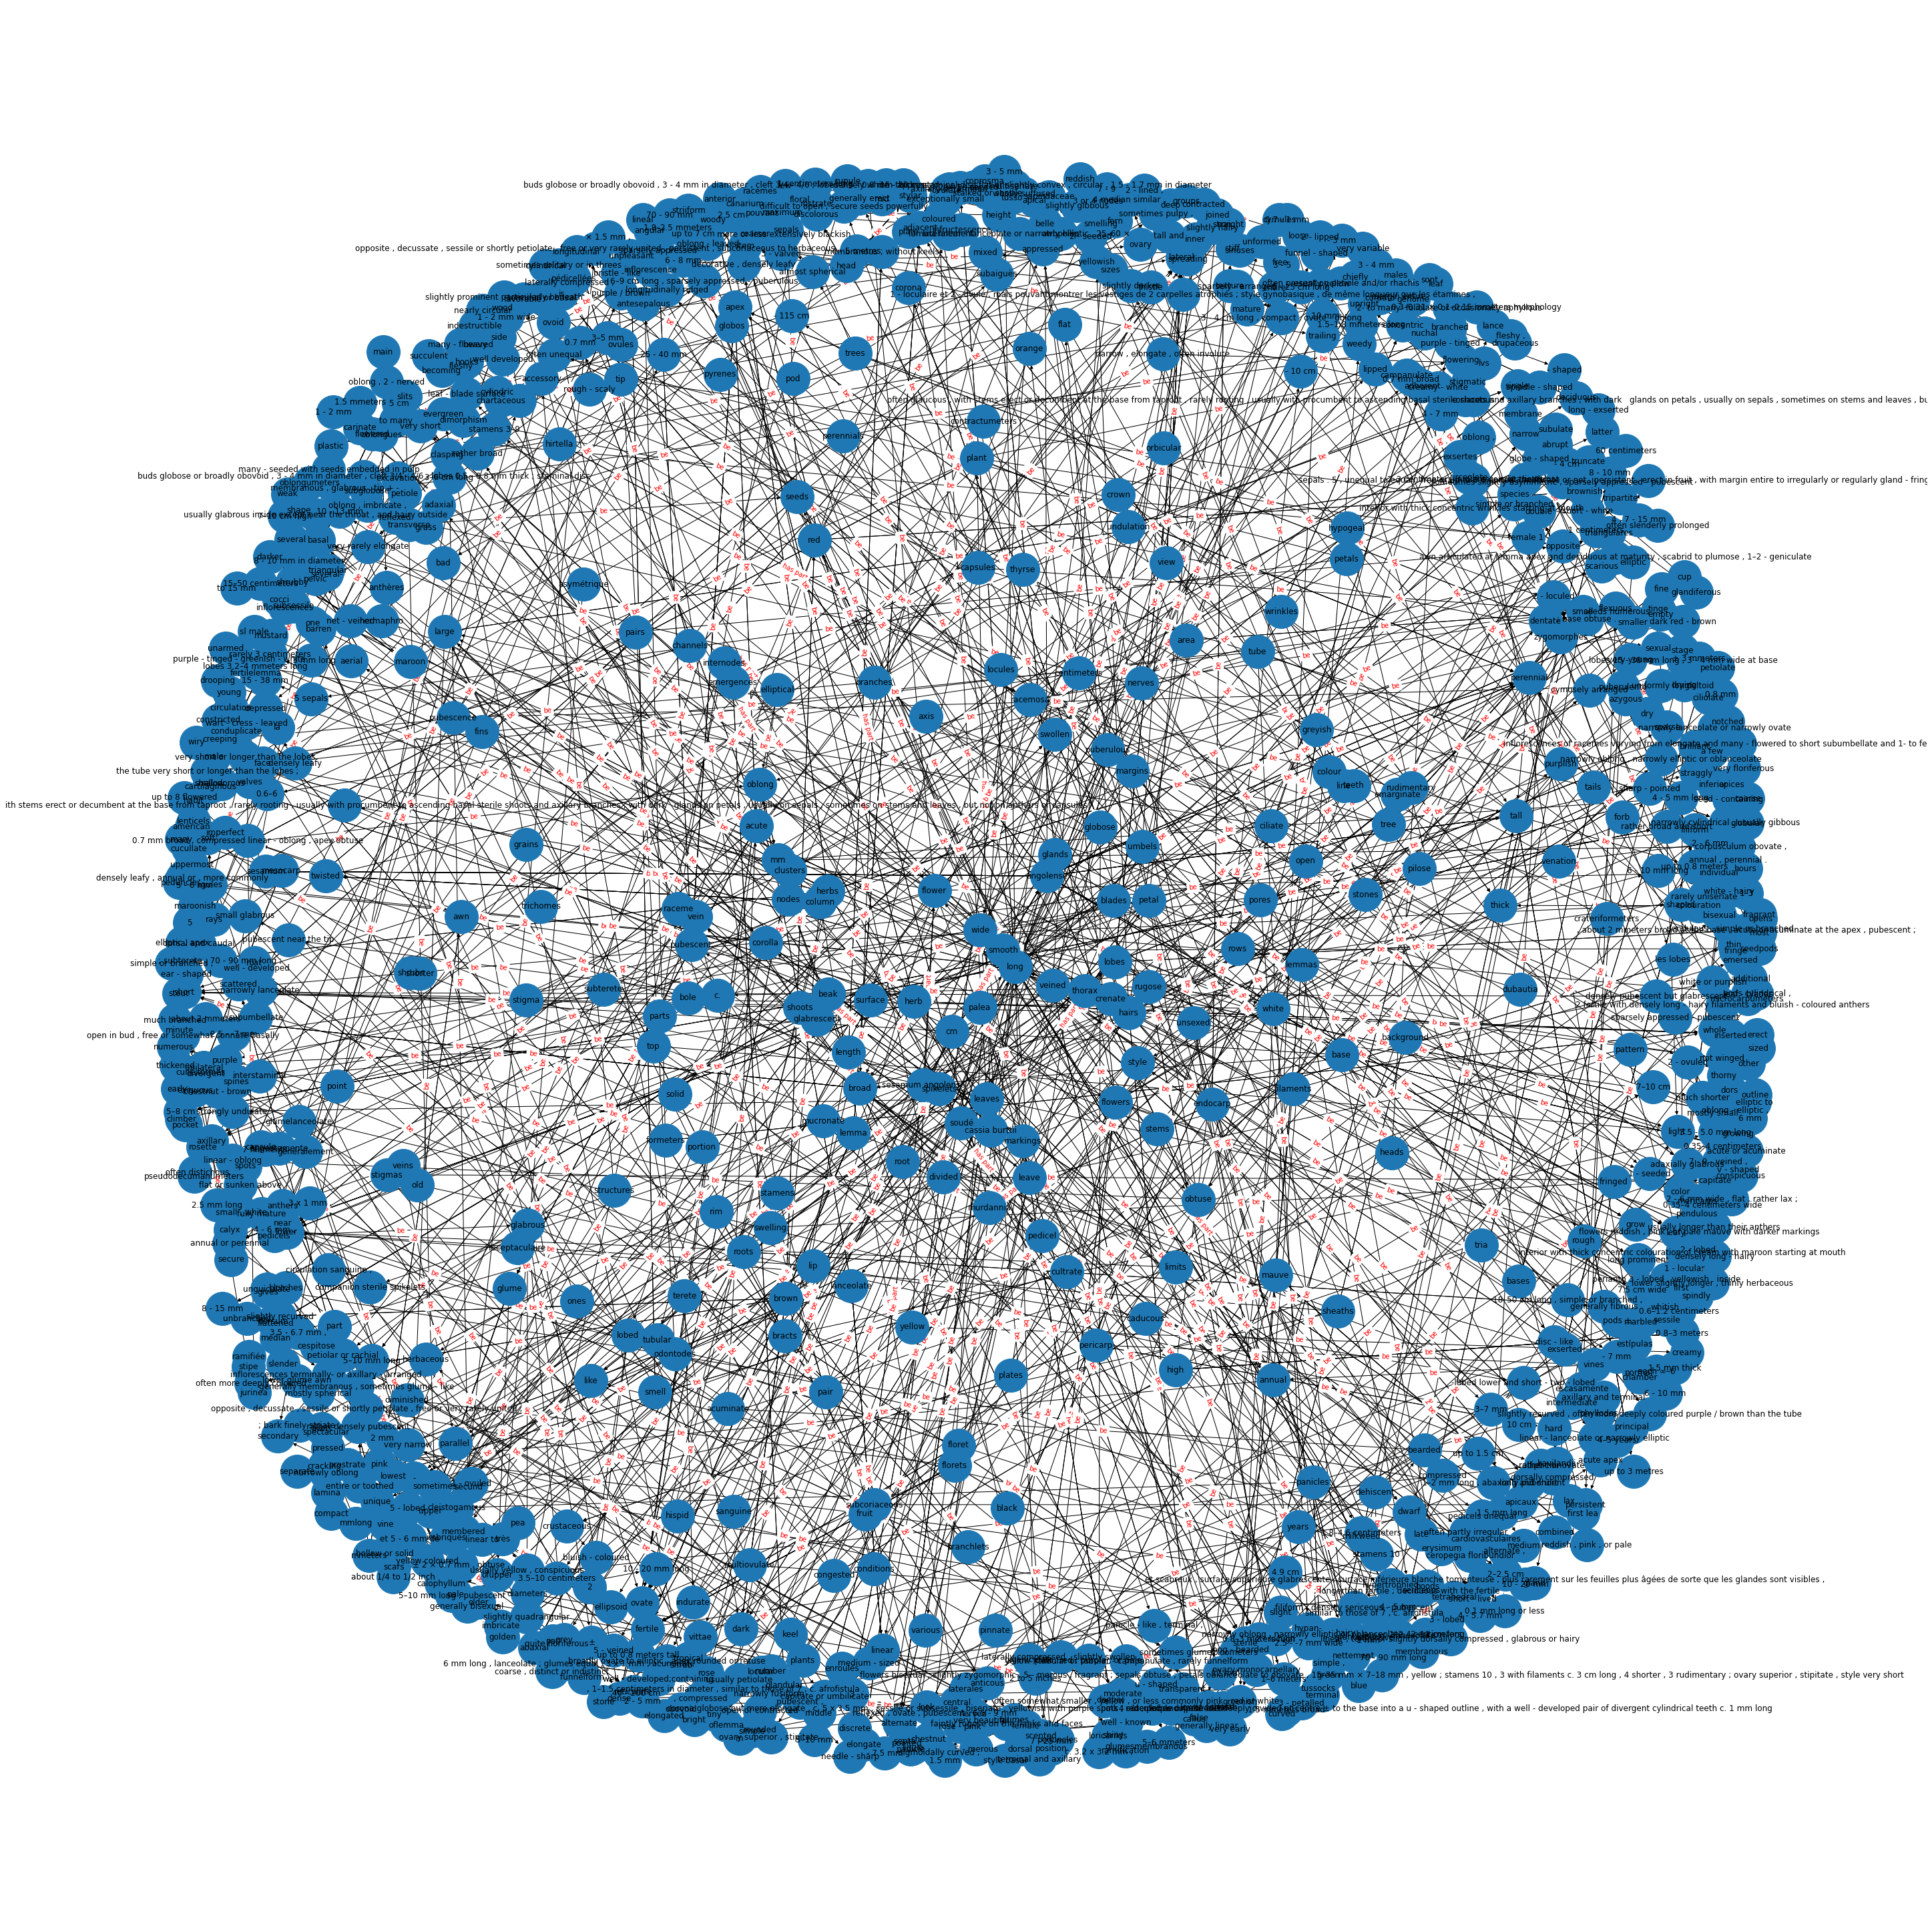

In [20]:
plot_kg(df)